# Train Koopman Neural Forecaster on TCTracks data

For demonstration, we nere train the Koopman Neural Forecaster for a small number of epochs on an exemplary dataset of tropical cyclone tracks.

In [1]:
import torch
import numpy as np
from torch.utils import data
from klearn_tcyclone.climada.tc_tracks import TCTracks
from sklearn.model_selection import train_test_split
from klearn_tcyclone.knf_data_utils import TCTrackDataset
from klearn_tcyclone.KNF.modules.models import Koopman
from torch import nn
import time
from klearn_tcyclone.KNF.modules.train_utils import eval_epoch_koopman
from klearn_tcyclone.KNF.modules.train_utils import train_epoch_koopman
from matplotlib import pyplot as plt
from klearn_tcyclone.data_utils import (
    LinearScaler,
)
from klearn_tcyclone.plot_utils import plot_TCTrackDataset_item_2D, plot_TCTrackDataset_item_2D_with_prediction
from klearn_tcyclone.KNF.modules.eval_metrics import RMSE_TCTracks
from klearn_tcyclone.knf_data_utils import TCTrackDataset

Import example TCTracks data.

In [2]:
# tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2001), basin='NA', correct_pres=False)
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2021), basin='NA', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\xarray\backends\plugins.py:75: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2024-10-12 19:44:39,778 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 393


Split TCTracks into train and test datasets.

In [3]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

Set model and training parameter.

In [4]:
# feature_list = ["lat", "lon"]
feature_list = ["lat", "lon", "central_pressure"]

In [5]:
seed=0 
dataset="Traj" 
data_dir="data/PlayerTraj/" 
num_feats=len(feature_list)
train_output_length=15 
input_dim=3 
input_length=21 
hidden_dim=128 
latent_dim=32 
num_layers=4 
control_num_layers=3 
control_hidden_dim=64 
transformer_dim=64 
transformer_num_layers=3 
batch_size=32
test_output_length=train_output_length - 2
# num_steps can be chosen differently to train_output_length.
num_steps=15
jumps=2 
learning_rate=0.001 
num_epochs = 5

encoder_hidden_dim = hidden_dim
decoder_hidden_dim = hidden_dim
encoder_num_layers = num_layers
decoder_num_layers = num_layers
output_dim = input_dim
use_revin = True
use_instancenorm = True
regularize_rank = False
add_global_operator = True
add_control = True
num_sins = -1
num_poly = -1
num_exp = -1
num_heads = 1
dropout_rate = 0
decay_rate = 0.9
min_epochs = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


Define evaluation metric and train, eval and test datasets.

In [6]:
scaler = LinearScaler()

eval_metric = RMSE_TCTracks
dataset = TCTrackDataset
dataset_str = "TCTracks"

train_set = TCTrackDataset(
    input_length=input_length,
    output_length=train_output_length,
    tc_tracks=tc_tracks_train,
    feature_list=feature_list,
    mode="train",
    jumps=jumps,
    scaler=scaler,
    fit=True,
)
valid_set = TCTrackDataset(
    input_length=input_length,
    output_length=train_output_length,
    tc_tracks=tc_tracks_train,
    feature_list=feature_list,
    mode="valid",
    jumps=jumps,
    scaler=scaler,
    fit=False,
)
test_set = TCTrackDataset(
    input_length=input_length,
    output_length=test_output_length,
    tc_tracks=tc_tracks_test,
    feature_list=feature_list,
    mode="test",
    # mode="test",
    # jumps=jumps,
    scaler=scaler,
    fit=False,
)

train_loader = data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=1
)
valid_loader = data.DataLoader(
    valid_set, batch_size=batch_size, shuffle=True, num_workers=1
)
test_loader = data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, num_workers=1
)

Plotting some exemplary time sequences. Crosses are input points, triangles are target output points.

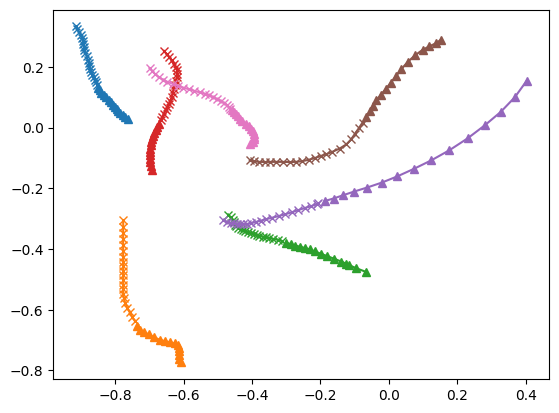

In [7]:
fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 7)):
    plot_TCTrackDataset_item_2D(train_set, idx, ax, color=f"C{i}")

Set up model name and model for training. We use the additive combination of global and local Koopman operators in the following.

In [8]:
model_name = (
    "Koopman_"
    + dataset_str
    + "_seed{}_jumps{}_poly{}_sin{}_exp{}_bz{}_lr{}_decay{}_dim{}_inp{}_pred{}_num{}_enchid{}_dechid{}_trm{}_conhid{}_enclys{}_declys{}_trmlys{}_conlys{}_latdim{}_RevIN{}_insnorm{}_regrank{}_globalK{}_contK{}"
    .format(
        seed,
        jumps,
        num_poly,
        num_sins,
        num_exp,
        batch_size,
        learning_rate,
        decay_rate,
        input_dim,
        input_length,
        train_output_length,
        num_steps,
        encoder_hidden_dim,
        decoder_hidden_dim,
        transformer_dim,
        control_hidden_dim,
        encoder_num_layers,
        decoder_num_layers,
        transformer_num_layers,
        control_num_layers,
        latent_dim,
        use_revin,
        use_instancenorm,
        regularize_rank,
        add_global_operator,
        add_control,
    )
)
print(model_name)

model = Koopman(
    # number of steps of historical observations encoded at every step
    input_dim=input_dim,
    # input length of ts
    input_length=input_length,
    # number of output features
    output_dim=output_dim,
    # number of prediction steps every forward pass
    num_steps=num_steps,
    # hidden dimension of encoder
    encoder_hidden_dim=encoder_hidden_dim,
    # hidden dimension of decoder
    decoder_hidden_dim=decoder_hidden_dim,
    # number of layers in the encoder
    encoder_num_layers=encoder_num_layers,
    # number of layers in the decoder
    decoder_num_layers=decoder_num_layers,
    # number of feature
    num_feats=num_feats,
    # dimension of finite koopman space
    latent_dim=latent_dim,
    # whether to learn a global operator shared across all time series
    add_global_operator=add_global_operator,
    # whether to use a feedback module
    add_control=add_control,
    # hidden dim in the control module
    control_hidden_dim=control_hidden_dim,
    # number of layers in the control module
    use_revin=use_revin,  # whether to use reversible normalization
    control_num_layers=control_num_layers,
    # whether to use instance normalization on hidden states
    use_instancenorm=use_instancenorm,
    # Regularize rank.
    regularize_rank=regularize_rank,
    # number of pairs of sine and cosine measurement functions
    num_sins=num_sins,
    # the highest order of polynomial functions
    num_poly=num_poly,
    # number of exponential functions
    num_exp=num_exp,
    # Number of the head the transformer encoder
    num_heads=num_heads,
    # hidden dimension of tranformer encoder
    transformer_dim=transformer_dim,
    # number of layers in the transformer encoder
    transformer_num_layers=transformer_num_layers,
    # dropout rate of MLP modules
    dropout_rate=dropout_rate,
    # whether to combine the global and local Koopman operators multiplicative or additive
    global_local_combination="additive"
).to(device)

Koopman_TCTracks_seed0_jumps2_poly-1_sin-1_exp-1_bz32_lr0.001_decay0.9_dim3_inp21_pred15_num15_enchid128_dechid128_trm64_conhid64_enclys4_declys4_trmlys3_conlys3_latdim32_RevINTrue_insnormTrue_regrankFalse_globalKTrue_contKTrue


c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [9]:
print("number of params:",
    sum(p.numel() for p in model.parameters() if p.requires_grad))

number of params: 168355


We can plot predictions for exemplary time sequences. Crosses are input points, triangles are target output points, and squares are the predictions of the model.

Since the model is not yet trained, predictions are completely independent from the input sequence.

c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\torch\nn\modules\instancenorm.py:88: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "
c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\torch\nn\modules\instancenorm.py:88: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in nu

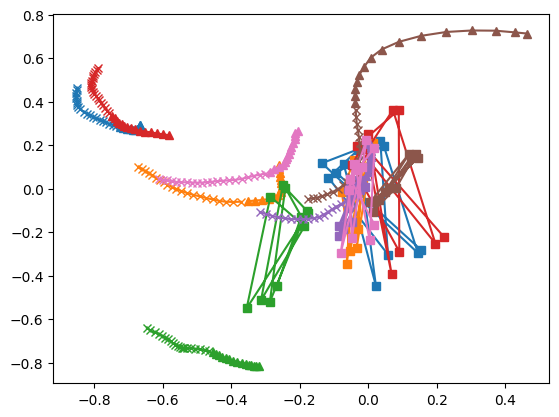

In [10]:
prediction_steps = 11

fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 7)):
    plot_TCTrackDataset_item_2D_with_prediction(train_set, idx, prediction_steps, model, ax, color=f"C{i}", num_steps = None)

Set upt optimizer and training scheduler.

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=2, gamma=decay_rate
)  # stepwise learning rate decay
loss_fun = nn.MSELoss()

We test the training run for a small number of epochs (takes around 2min on CPU).

In [12]:
num_epochs = 6
last_epoch = 0

In [13]:
all_train_rmses, all_eval_rmses = [], []
best_eval_rmse = 1e6

for epoch in range(last_epoch, num_epochs):
    start_time = time.time()

    train_rmse = train_epoch_koopman(
        train_loader,
        model,
        loss_fun,
        optimizer,
        regularize_rank=regularize_rank)
    eval_rmse, _, _ = eval_epoch_koopman(
        valid_loader, model, loss_fun, regularize_rank=regularize_rank)

    if eval_rmse < best_eval_rmse:
        best_eval_rmse = eval_rmse
        best_model = model

    all_train_rmses.append(train_rmse)
    all_eval_rmses.append(eval_rmse)

    if np.isnan(train_rmse) or np.isnan(eval_rmse):
        raise ValueError("The model generate NaN values")

    epoch_time = time.time() - start_time
    scheduler.step()
    print("Epoch {} | Learning rate {} | T: {:0.2f} | Train RMSE: {:0.3f} | Valid RMSE: {:0.3f}"
            .format(epoch + 1, optimizer.param_groups[0]["lr"], epoch_time / 60, train_rmse, eval_rmse))



c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\torch\nn\modules\instancenorm.py:88: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "
c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\torch\nn\modules\instancenorm.py:88: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


Epoch 1 | Learning rate 0.001 | T: 0.48 | Train RMSE: 0.366 | Valid RMSE: 0.249
Epoch 2 | Learning rate 0.0009000000000000001 | T: 0.48 | Train RMSE: 0.237 | Valid RMSE: 0.215
Epoch 3 | Learning rate 0.0009000000000000001 | T: 0.48 | Train RMSE: 0.216 | Valid RMSE: 0.209
Epoch 4 | Learning rate 0.0008100000000000001 | T: 0.50 | Train RMSE: 0.211 | Valid RMSE: 0.192
Epoch 5 | Learning rate 0.0008100000000000001 | T: 0.49 | Train RMSE: 0.196 | Valid RMSE: 0.203
Epoch 6 | Learning rate 0.000729 | T: 0.53 | Train RMSE: 0.195 | Valid RMSE: 0.198


In [14]:
test_rmse, test_preds, test_tgts = eval_epoch_koopman(test_loader, best_model,
                                                loss_fun)
test_rmse, test_preds.shape, test_tgts.shape

(np.float64(0.1910066553101829), (87, 13, 3), (87, 13, 3))

Text(0, 0.5, 'RMSE')

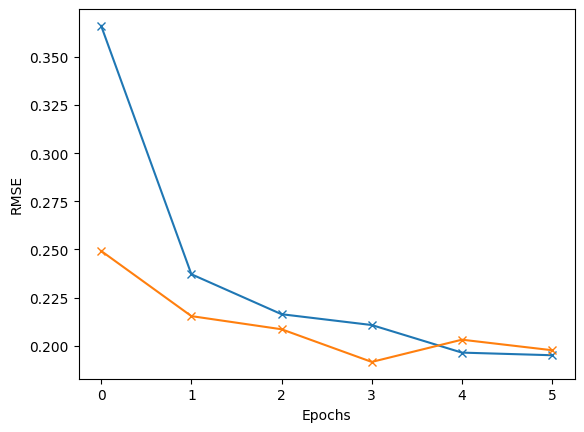

In [16]:
epochs = range(last_epoch, num_epochs)
plt.plot(epochs, all_train_rmses, "-x", label="Train RMSE")
plt.plot(epochs, all_eval_rmses, "-x", label="Eval RMSE")
plt.xlabel("Epochs")
plt.ylabel("RMSE")

After training, the predicted sequences (squares) look much better. Still the predictions are very bad, a larger number of epochs is certainly needed.

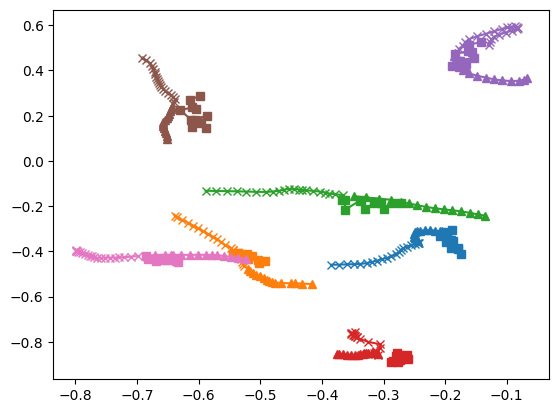

In [17]:
fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 7)):
    plot_TCTrackDataset_item_2D_with_prediction(train_set, idx, 11, model, ax, color=f"C{i}", num_steps = None)

Looks good. We observe a reduction of train and eval rmse over epochs.